In [1]:
from pulser import Pulse, Sequence, Register
from pulser_simulation import QutipEmulator
from pulser.devices import Chadoq2
from pulser.waveforms import InterpolatedWaveform
import matplotlib.pyplot as plt
import numpy as np
import igraph
from itertools import combinations
from collections import defaultdict
from scipy.optimize import minimize
import networkx as nx
from scipy.spatial.distance import pdist, squareform

In [2]:
import warnings
warnings.filterwarnings("ignore")

# Solving the Max-cut problem with Neutral Atoms

### **Victor Onofre**

# Part I: Max-cut problem 

The goal of the max-cut problem is to:

> **Have as many cut edges as possible. Where an edge is cut if its endpoints have different colors**

The output is a "2-coloring" of $V$: Each vertex is designated a color (examples: blue or red)

The maximum cut can be formaulated as an optimization problem:

$$ \max_{s}\frac{1}{2} \sum_{ij \in E}  (1-s_{i}s_{j}), \quad s_{i} \in \{-1 , +1 \}$$

> Same sign: No edge is cut (no contribution to the objective function) $\rightarrow \frac{1}{2} (1-s_{i}s_{j}) = 0$

> Different sign: An edge is cut (contribution to the objective function) $\rightarrow \frac{1}{2} (1-s_{i}s_{j}) = 1$

## Max cut as a QUBO problem

The maximum cut problem can be naturally transformed into the Quadratic unconstrained binary optimization (QUBO) model as follows: 

If we look for a maximum cut in our graph, then we are looking for a way to split the nodes into two groups so that there are as many edges as possible between the groups.We can define a binary variable $x_{i}$ for each node:

> $x_{i} = 0 \rightarrow$ The node is in the first subset 

> $x_{i} = 1 \rightarrow$ The node is in the second subset 

Defining the edge_score(i,j) as 1 if the two nodes are in a different subset, 0 otherwise, we can build the followin table: 


| $x_{i}$  | $x_{j}$  |  edge_score(i,j) |  
|---|---|---|
| 0  | 0  | 0  |  
| 0  | 1  | 1  |
| 1  | 0  | 1  |
| 1  | 1  | 1  |

The edge_score is define as $x_{i} + x_{j} - 2 x_{i} x_{j}$. Then for the entire graph, the objective funtion can be written as:

$$ \max \sum_{(i,j) \in E} (x_{i} + x_{j} - 2x_{i}x_{j}) $$

Multiplying by -1 to the convert to a minimization problem: 

$$ \min \sum_{(i,j) \in E} (- x_{i} - x_{j} + 2x_{i}x_{j}) $$

We can build a function to build the QUBO matrix for an arbitrary graph:

In [3]:
def build_qubo_matrix(graph):
    
    #Number of nodes in the graph
    num_nodes = len(graph.nodes) 
    
    # Initialize our QUBO matrix
    Q_matrix = np.zeros((num_nodes, num_nodes))
    
    # Update Q matrix for every edge in the graph
    for i, j in graph.edges:
        Q_matrix[i][i]+= -1
        Q_matrix[j][j]+= -1
        Q_matrix[i][j]+= 2
        
    return Q_matrix

## Brute force solution 

In [4]:
def brute_force(qubo_matrix):
    """Brute force solver for the QUBO problem

    Args:
        qubo_matrix: QUBO matrix representing the problem 

    Returns:
        sort_solutions: Dictionary with the solutions in order
    """
    
    
    
    bitstrings = [np.binary_repr(i, len(qubo_matrix)) for i in range(2 ** len(qubo_matrix))]
    costs = []
    
    # this takes exponential time with the dimension of the QUBO
    
    for b in bitstrings:
        z = np.array(list(b), dtype=int)
        cost = z.T @ qubo_matrix @ z
        costs.append(cost)
        zipped = zip(bitstrings, costs)
    
    sort_solutions = sorted(zipped, key=lambda x: x[1])
    
    return sort_solutions

# Part II: Encoding a graph using a neutral atoms device

In this way, the low-energy configurations of the atom array at $\Omega = 0$, corresponds to large independent sets of the unit-disk graph.

**Modeling Question 1**

*Please, explain how you would encode a graph using a neutral-atom quantum
computer?*

> How would encode each vertex of the graph?

We can use a unit-disk graph since they are in one-to-one correspondence with atom arrangements in 2D. Specifically, each atom represents a vertex, and we identify the blockade radius with the unit-disk radius of the graph. A unit-disk graph is a graph $G = (V,E)$ with vertices $V$ and edges $E$ that can be embedded in the 2D Euclidean plane such that has an edge between any two vertices whose Euclidean distance is less than 1.

> How would encode the adjacence matrix of the graph?

We can encode the off-diagonal terms of the adjencece matrix by using the Rydberg interaction between atoms. As the interaction $U$ depends on the pairwise distance ($C_{6}/ r_{ij}^6$) between atoms $i$ and $j$, we attempt to find the optimal positions of the atoms in the Register that replicate best the off-diagonal terms of the matrix.

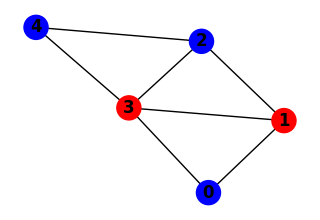

In [6]:
Graph_Example_encoding  = nx.Graph()
Graph_Example_encoding .add_edges_from([[0,1],[1,2], [1,3], [0,3],[3,2],[3,4],[2,4]])

plt.figure(figsize=(3,2)) 
nx.draw(Graph_Example_encoding ,with_labels=True,node_color = ['b','r','b','r','b'],font_weight='bold')

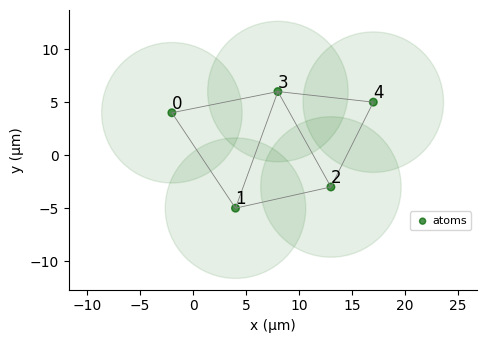

In [7]:
qubits3 = {'0': (-2,4), '1': (4,-5), '2': (13, -3), '3': (8,6), '4': (17,5)} #, '3': (8,6), '4': (-8, 6)
reg3 = Register(qubits3)
reg3.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True
)

In [8]:
Q_example_encoding = build_qubo_matrix(Graph_Example_encoding)
Q_example_encoding

array([[-2.,  2.,  0.,  2.,  0.],
       [ 0., -3.,  2.,  2.,  0.],
       [ 0.,  0., -3.,  2.,  2.],
       [ 0.,  0.,  0., -4.,  2.],
       [ 0.,  0.,  0.,  0., -2.]])

## Create register as an optimization process

In [9]:
def evaluate_mapping(new_coords, *args):
    """Cost function to minimize. Ideally, the pairwise
    distances are conserved"""
    Q, shape = args
    new_coords = np.reshape(new_coords, shape)
    new_Q = squareform(
        Chadoq2.interaction_coeff/ pdist(new_coords) ** 6
    )
    return np.linalg.norm(new_Q - Q)

def create_coordinates(qubo_matrix,
                    optimizer= "COBYLA",  
                    scale_factor =3):
    """Creation of coordinates for the register in the quantum device 
       given a QUBO matrix

    Args:
        qubo_matrix: QUBO matrix representing the problem 
        optimizer: Minimizer to use from scipy. Default COBYLA
        scale_factor: Factor to scale the QUBO matrix. Default 3

    Returns:
        coordinates: The coordinates for the register
    """
    
    size_matrix = len(qubo_matrix)
    
    shape = (size_matrix, 2)
    costs = []
    np.random.seed(0)
    
    x0 = np.random.random(shape).flatten()
    
    res = minimize(
        evaluate_mapping,
        x0,
        args=(qubo_matrix*scale_factor, shape),
        method=optimizer,
        tol=1e-6,
        options={"maxiter": 200000},
    )
    
    coordinates = np.reshape(res.x, (size_matrix, 2))

    return coordinates

In [10]:
coords_example = create_coordinates(Q_example_encoding)
coords_example

array([[ 5.24411836, 12.9150815 ],
       [ 8.71185464,  2.43707612],
       [ 1.37077413, -5.80555067],
       [-2.09555962,  4.67203285],
       [-9.43722001, -3.56925211]])

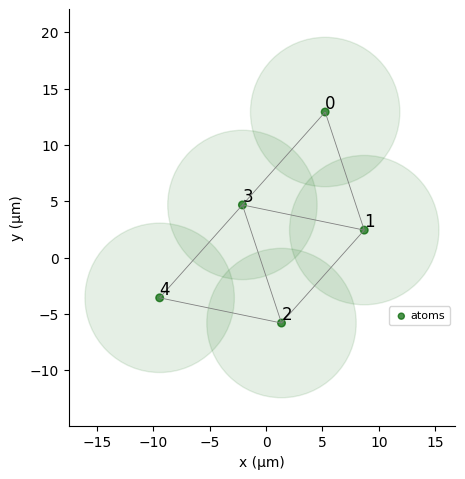

In [11]:
qubits_example = dict(enumerate(coords_example))
reg_example = Register(qubits_example)
reg_example.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

# Part III: Variational Quantum Adabiatic Algorithm (VQAA ) with Neutral Atoms

**Modeling Question 2**

*Please, explain how you would solve the Max-Cut problem on a given graph using a
neutral-atom quantum computer?*


> Can you provide any proof of optimality?


In [72]:
def simple_adiabatic_sequence(device, register, time, Omega=3.271543, detuning=5) -> Sequence:
    """Creates the adiabatic sequence

    Args:
        device: physical device simulation
        Omega: Frecuency
        register: arrangement of atoms in a quantum processor
        time: time of the adiabatic process
        detuning: detuning use

    Returns:
        sequence
    """
    delta_0 = -detuning
    delta_f = -delta_0

    adiabatic_pulse = Pulse(
        InterpolatedWaveform(time, [1e-9, Omega, 1e-9]),
        InterpolatedWaveform(time, [delta_0, 0, delta_f]),
        0,
    )

    sequence = Sequence(register, device)
    sequence.declare_channel("ising", "rydberg_global")

    sequence.add(adiabatic_pulse, "ising")

    return sequence

In [73]:
random_detuning1

2.144557339801518

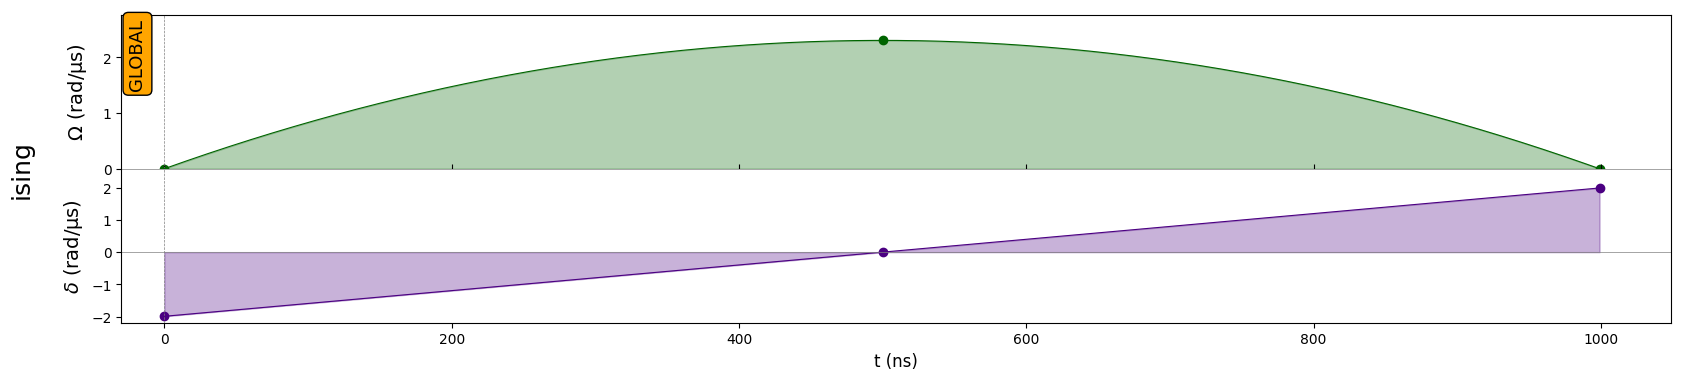

In [124]:
# QAOA with random parameters

#np.random.seed(123) # Ensures reproducibility of the tutorial

omega_range=(1, 5)
detuning_range=(1, 5)
time_range=(1, 10)

random_omega = np.random.uniform(omega_range[0], omega_range[1])
random_detuning1 = np.random.uniform(detuning_range[0], detuning_range[1])
random_time1 = 1000 * np.random.randint(time_range[0], time_range[1])

assigned_seq = simple_adiabatic_sequence(
        Chadoq2,
        reg_example,
        random_time1,
        Omega=random_omega,
        detuning=random_detuning1,
    )
assigned_seq.draw()

In [81]:
# Building the quantum loop

def simple_quantum_loop(parameters, register):
    params = np.array(parameters)

    parameter_time, parameter_omega, parameter_detuning = np.reshape(params.astype(int), 3)
    seq = simple_adiabatic_sequence(
        Chadoq2,
        register,
        parameter_time,
        Omega=parameter_omega,
        detuning=parameter_detuning,
    )

    simul = QutipEmulator.from_sequence(seq, sampling_rate=0.1)
    res = simul.run()
    counts = res.sample_final_state(N_samples=5000)  # Sample from the state vector
    # print(counts)

    return counts

def plot_distribution(count_dist):
    count_dist = dict(sorted(count_dist.items(), key = lambda item: item[1], reverse = True))
    plt.figure(figsize= (6,4))
    plt.xlabel('bitstings')
    plt.ylabel('counts')
    plt.bar(count_dist.keys(), count_dist.values(), width = 0.5)
    plt.xticks(rotation = 'vertical')
    plt.show()

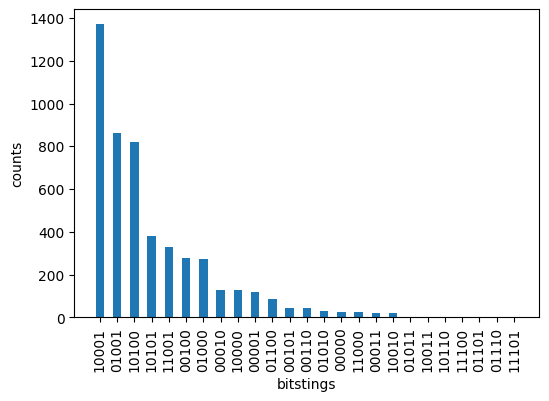

In [84]:
# QAOA with random parameters

np.random.seed(123) # Ensures reproducibility of the tutorial


omega_range=(1, 5)
detuning_range=(1, 5)
time_range=(8, 25)

random_omega = np.random.uniform(omega_range[0], omega_range[1])
random_detuning1 = np.random.uniform(detuning_range[0], detuning_range[1])
random_time1 = 1000 * np.random.randint(time_range[0], time_range[1])

random_counts = simple_quantum_loop(np.r_[random_time1, random_omega, random_detuning1],reg_example)
plot_distribution(random_counts)

# Part III: Optimization

In [87]:
def get_cost(bitstring, Q):
    """Get the cost of the problem 

    Args:
        Q: QUBO matrix
        bitstring: Solution in bitstring format

    Returns:
        cost
    """
    z = np.array(list(bitstring), dtype=int)
    cost = z.T @ Q @ z
    return cost


def get_cost_average(counts_distr, Q):
    """Get the average cost of the problem 

    Args:
        counts_distr: Counts distribution from the sequence simulation
        Q: QUBO matrix

    Returns:
        Average cost
    """
    cost = sum(counts_distr[key] * get_cost(key, Q) for key in counts_distr)
    return cost / sum(counts_distr.values())  # Divide by total samples



def func_to_min(param, *args):
    """Function to minimize

    Args:
        param: Parameters beta and gamma for the sequence
        args: QUBO matrix, sequence and p layers

    Returns:
        Average cost
    """
    Q, register = args
    #sequence  = args[0][1]
    #p_l = args[0][2]
    C = simple_quantum_loop(param, register)
    cost = get_cost_average(C, Q)
    return cost

In [100]:
def VQAA(
    atomic_register,
    qubo_matrix,
    func_to_min,
    omega_range=(1, 5),
    detuning_range=(1, 5),
    time_range=(8, 25),
    minimizer_method="Nelder-Mead",
    repetitions=10,
    simple_sequence=True,
) -> list:
    """Main function for the VQAA algorithm.

    Args:
        atomic_register: The atomic register representing the problem in the quantum device
        qubo_matrix: QUBO matrix representing the problem 
        function_to_min: Function representing the problem to minimize
        omega_range: The range of frequencies to used for the optimizer parameters. Default (1,5)
        detuning_range: The range of detuning to used for the optimizer parameters. Default (1,5)
        time_range:Range of time evolution for QAA to used in optimizer parameters.Default (8,25)
        minimizer_method: Minimizer to use from scipy. Default Nelder-Mead
        repetitions: The number of times to repeat the optimization. Default(10)

    Returns:
        list: List of all final parameters.
    """
    scores = []
    params = []
    testing = []
    for repetition in range(repetitions):
        random_omega = np.random.uniform(omega_range[0], omega_range[1])
        random_detuning = np.random.uniform(detuning_range[0], detuning_range[1])
        random_time = 1000 * np.random.randint(time_range[0], time_range[1])
        
        res = minimize(
            func_to_min,
            args=(qubo_matrix, atomic_register),
            x0=np.r_[random_time1, random_omega, random_detuning1],
            method=minimizer_method,
            tol=1e-5,
            options={"maxiter": 20},
            )

        # print(res.fun)
        scores.append(res.fun)
        params.append(res.x)

    optimal_parameters = params[np.argmin(scores)]

    return optimal_parameters

In [105]:
def plot_solution(graph, Q_matrix, optimal_parameters, register):
    
    #sequence = define_sequence(register,p_layers )
    optimial_count_dict = simple_quantum_loop(optimal_parameters, register)
    best_solution = max(optimial_count_dict, key=optimial_count_dict.get)
    colors = ['b' if best_solution[node] == '0' else 'r' for node in graph] # Define the colors of the nodes for the best solution
    best_cut = get_cost(best_solution, Q_matrix)
    print(f"Best solution: {best_solution} with {-best_cut} cuts")
    
    #plot_distribution(optimial_count_dict)
    plt.figure(figsize=(3,2)) 
    nx.draw(graph,with_labels=True, node_color = colors,font_weight='bold')

In [108]:
opt_parameters = VQAA(reg_example,
                      Q_example_encoding,
                      func_to_min)

In [114]:
print("Optimal time evolution (ns):", opt_parameters[0])
print("Optimal omega:", opt_parameters[1])
print("Optimal detuning:", opt_parameters[2])

Optimal time evolution (ns): 20369.248773617393
Optimal omega: 2.4254864225153043
Optimal detuning: 5.1987615271350425


Best solution: 10101 with 5.0 cuts


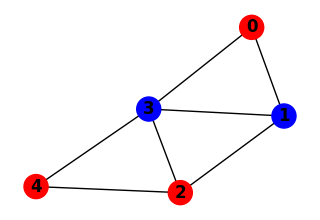

In [110]:
plot_solution(Graph_Example_encoding , 
              Q_example_encoding,
              opt_parameters,
              reg_example)

In [112]:
brute_force(Q_example_encoding)[:7]

[('00110', -5.0),
 ('01001', -5.0),
 ('01010', -5.0),
 ('01011', -5.0),
 ('10100', -5.0),
 ('10101', -5.0),
 ('10110', -5.0)]

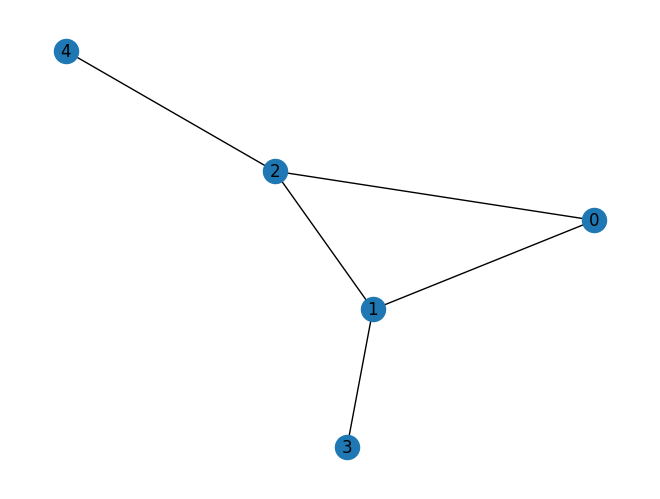

In [115]:
bull_graph = nx.bull_graph()
nx.draw(bull_graph,with_labels=True)   

In [117]:
Q_matrix_bull = build_qubo_matrix(bull_graph)
coords_matrix_bull = create_coordinates(Q_matrix_bull, optimizer ='Nelder-Mead' )

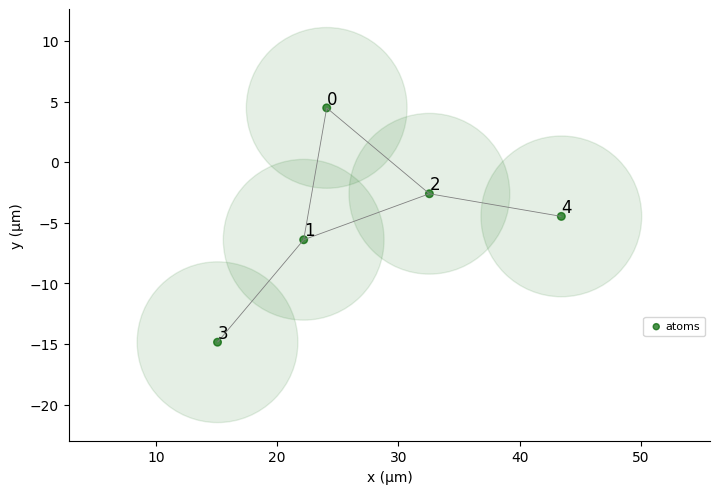

In [119]:
qubits_test_bull = dict(enumerate(coords_matrix_bull))
reg_test_bull = Register(qubits_test_bull)
reg_test_bull.draw(
    blockade_radius=Chadoq2.rydberg_blockade_radius(1.0),
    draw_graph=True,
    draw_half_radius=True,
)

In [120]:
opt_parameters_bull = VQAA(reg_test_bull,
                           Q_matrix_bull,
                           func_to_min)

In [121]:
print("Optimal time evolution (ns):", opt_parameters_bull[0])
print("Optimal omega:", opt_parameters_bull[1])
print("Optimal detuning:", opt_parameters_bull[2])

Optimal time evolution (ns): 20731.484354161905
Optimal omega: 3.896279017512266
Optimal detuning: 3.7612839686652304


Best solution: 10011 with 4.0 cuts


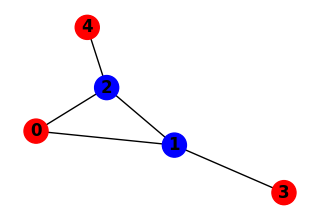

In [122]:
plot_solution(bull_graph , 
              Q_matrix_bull,
              opt_parameters_bull,
              reg_test_bull)

In [123]:
brute_force(Q_matrix_bull)[:7]

[('00110', -4.0),
 ('01001', -4.0),
 ('01100', -4.0),
 ('10011', -4.0),
 ('10110', -4.0),
 ('11001', -4.0),
 ('00100', -3.0)]

## References

[1] https://arxiv.org/abs/1411.4028

[2] https://pulser.readthedocs.io/en/stable/tutorials/qubo.html

[3] https://arxiv.org/abs/2207.13030

[4] 